# Chest X-ray Image Report Generation (CXIRG) Original

## Install Required Modules

In [23]:
!pip install openpyxl
!pip install pandas
!pip install pillow
!pip install pytorch-ignite
!pip install scikit-learn
!pip install torch
!pip install transformers

## Import Required Modules

In [6]:
import os
import random
import torch

import numpy as np
import pandas as pd
import torch.nn as nn
import nltk
import cv2
import matplotlib.pyplot as plt

from ignite.metrics import Rouge
from pandas.core.common import random_state
from PIL import Image
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, VisionEncoderDecoderModel, ViTImageProcessor
from typing import Any, Dict, List
from torch.utils.data import DataLoader

c:\Users\kartg\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set The Random Seed

In [25]:
seed = 42

np.random.seed(seed=seed, )

random_state(state=seed, )

random.seed(a=seed, )

torch.manual_seed(seed=seed, )
torch.cuda.manual_seed(seed=seed, )
torch.cuda.manual_seed_all(seed=seed, )
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Set The Device & Initialize Models

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("nickmuchi/vit-finetuned-chest-xray-pneumonia", "emilyalsentzer/Bio_ClinicalBERT").to(device)

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

print(tokenizer.all_special_tokens)

tokenizer.add_special_tokens({
    "bos_token": tokenizer.cls_token,
    "eos_token": tokenizer.sep_token,
    "pad_token": tokenizer.pad_token,
    #"bos_token": "<|beginoftext|>",
    #"pad_token": "<|pad|>",
})

model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
#model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

model.decoder.resize_token_embeddings(len(tokenizer))

processor = ViTImageProcessor.from_pretrained("nickmuchi/vit-finetuned-chest-xray-pneumonia")

c:\Users\kartg\anaconda3\envs\myenv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nickmuchi/vit-finetuned-chest-xray-pneumonia and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertLMHeadModel were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.enc

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


## The CXIRG Dataset

In [27]:
class CXIRGDataset(Dataset):
    def __init__(self, data: List[Dict[str, Any]]) -> None:
        super(CXIRGDataset, self).__init__()
        self.data = data

    def __getitem__(self, index: int) -> Dict[str, Any]:
        return self.data[index]

    def __len__(self) -> int:
        return len(self.data)

## The Collate Function for The DataLoader

In [28]:
max_length = 256

def train_dl_collate_fn(one_batch_data: List[Dict[str, Any]]) -> Dict[str, Any]:
    names, pixel_values, reports = [], [], []

    for one_data in one_batch_data:
        names.append(one_data["name"])
        pixel_values.append(one_data["image"])
        reports.append(one_data["text"])

    # Process images
    pixel_values = processor(images=pixel_values, return_tensors="pt").pixel_values
    
    # Tokenize reports
    label_ids = tokenizer(
        reports,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    ).input_ids

    return {
        "names": names,
        "pixel_values": pixel_values.to(device, dtype=torch.float32),
        "label_ids": label_ids.to(device, dtype=torch.int64)
    }

def valid_dl_collate_fn(one_batch_data: List[Dict[str, Any]]) -> Dict[str, Any]:
    names, pixel_values, reports = [], [], []

    for one_data in one_batch_data:
        names.append(one_data["name"])
        pixel_values.append(one_data["image"])
        reports.append(one_data["text"])

    # Process images
    pixel_values = processor(images=pixel_values, return_tensors="pt").pixel_values

    # Tokenize reports
    label_ids = tokenizer(
        reports,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    ).input_ids

    return {
        "names": names,
        "pixel_values": pixel_values.to(device, dtype=torch.float32),
        "label_ids": label_ids.to(device, dtype=torch.int64)
    }


## Image Preprocess

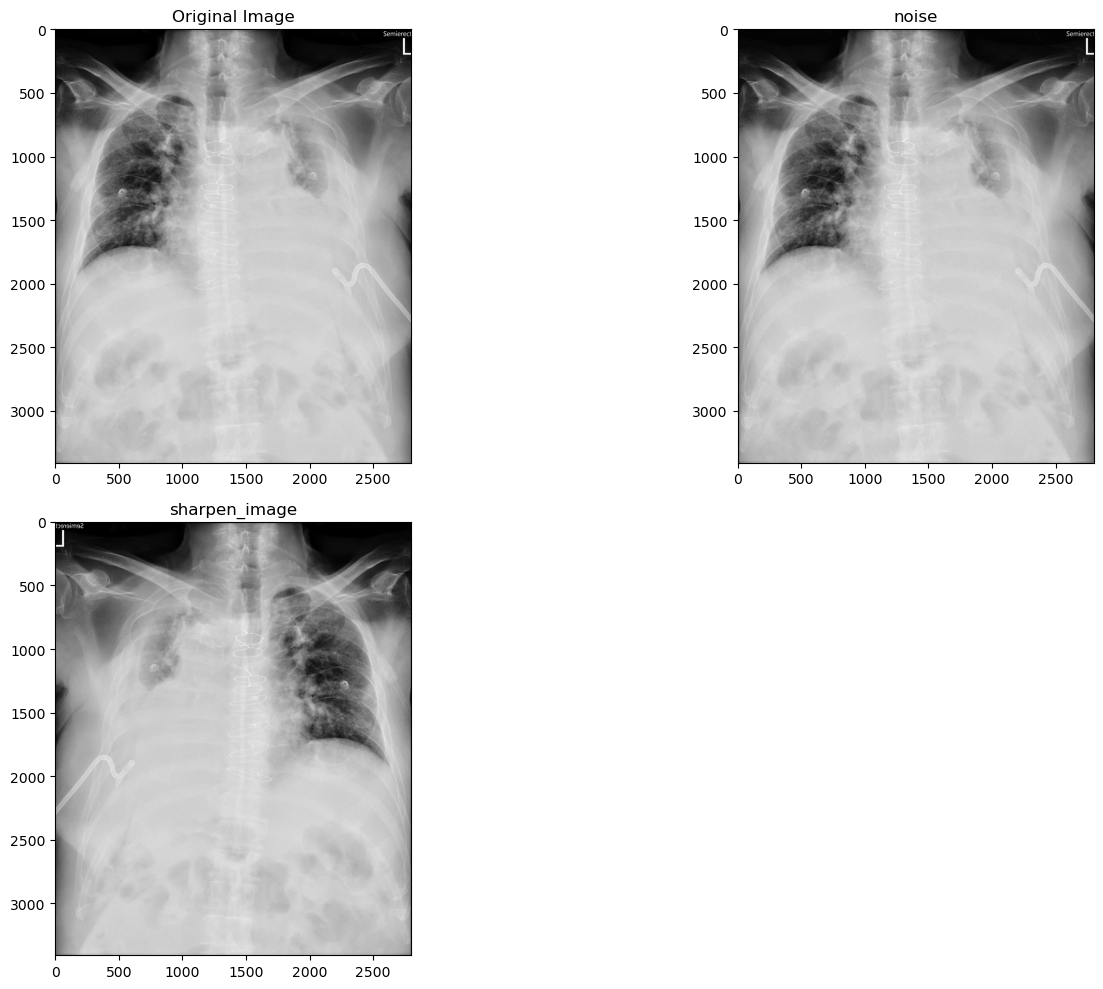

In [25]:
def gaussian_noise(image, mean=0, std=10):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255) 

def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(image, -1, kernel)
    return sharpened_image

def horizontal_flip(image):
    return cv2.flip(image, 1)

def gaussian_blur(image, kernel_size=(5, 5), sigma=1.0):
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image

def median_filter(image, kernel_size=1):
    return cv2.medianBlur(image, kernel_size)

def preprocess_xray(image_path):
    original_image = cv2.imread(image_path)
    sharpen_original_image = sharpen(original_image)

    noise = gaussian_noise(original_image).astype(np.uint8)
    noise_blur = gaussian_blur(noise)
    sharpen_noise__blur_image = sharpen(noise_blur)

    flip = horizontal_flip(original_image)
    sharpen_flip_image = sharpen(flip)

    return sharpen_original_image, sharpen_noise__blur_image, sharpen_flip_image

def save_images(images, image_names, output_dir):
    for image, name in zip(images, image_names):
        cv2.imwrite(f"{output_dir}/{name}.png", image)

image_path = 'CXIRG_Data/train_data/images/NLP_CHEST_012_1_1.png'
sharpen_original_image, sharpen_noise__blur_image, sharpen_flip_image = preprocess_xray(image_path)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(sharpen_original_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 2)
plt.title('noise')
plt.imshow(cv2.cvtColor(sharpen_noise__blur_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 3)
plt.title('sharpen_image')
plt.imshow(cv2.cvtColor(sharpen_flip_image, cv2.COLOR_BGR2RGB))

save_images([sharpen_original_image, sharpen_noise__blur_image, sharpen_flip_image], ['sharpen_original_image', 'sharpen_noise__blur_image', 'sharpen_flip_image'], 'output_images')

plt.tight_layout()
plt.show()


## Load The Train & Validation Data

In [26]:
report_path = "CXIRG_Data/train_data/reports.xlsx"
report_df = pd.read_excel(report_path)

image_dir_path = "CXIRG_Data/train_data/images"

train_data = []

for image_name in os.listdir(image_dir_path):
    image_path = os.path.join(image_dir_path, image_name)
    
    with Image.open(image_path) as img:
        if img.mode != "RGB":
            img = img.convert("RGB")
        text = report_df[report_df["name"] == image_name[:13]]["text"].values[0].replace("_x000D_", "\r")
        original, noise_blur, flip = preprocess_xray(image_path)
        train_data.append({
            "name": image_name[:13],
            "image": original,
            "text": text
        })
        train_data.append({
            "name": image_name[:13],
            "image": noise_blur,
            "text": text
        })
        train_data.append({
            "name": image_name[:13],
            "image": flip,
            "text": text
        })



train_dataset = CXIRGDataset(train_data)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dl_collate_fn)

for batch in train_dataloader:
    print(batch)

In [31]:
report_path = "CXIRG_Data/valid_data/reports.xlsx"
report_df = pd.read_excel(report_path)

image_dir_path = "CXIRG_Data/valid_data/images"

valid_data = []


for image_name in os.listdir(image_dir_path):
    image_path = os.path.join(image_dir_path, image_name)
    
    with Image.open(image_path) as img:
        if img.mode != "RGB":
            img = img.convert("RGB")
        _,_,_,img = preprocess_xray(image_path)
        text = report_df[report_df["name"] == image_name[:13]]["text"].values[0].replace("_x000D_", "\r")

        valid_data.append({
            "name": image_name[:13],
            "image": img,
            "text": text
        })

valid_dataset = CXIRGDataset(valid_data)

valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=valid_dl_collate_fn)

for batch in valid_dataloader:
    print(batch)

{'names': ['NLP_CHEST_002', 'NLP_CHEST_004', 'NLP_CHEST_011', 'NLP_CHEST_015'], 'pixel_values': tensor([[[[-0.6000, -0.5922, -0.5843,  ..., -0.7804, -0.7176, -0.5451],
          [-0.5137, -0.5137, -0.5137,  ..., -0.7882, -0.7804, -0.7490],
          [-0.5137, -0.5137, -0.5137,  ..., -0.7882, -0.7882, -0.7804],
          ...,
          [-0.7490, -0.7490, -0.7647,  ..., -0.9922, -0.9922, -0.9922],
          [-0.7490, -0.7569, -0.7647,  ..., -0.9922, -0.9922, -0.9922],
          [-0.7333, -0.7412, -0.7490,  ..., -0.9922, -0.9843, -0.9843]],

         [[-0.6000, -0.5922, -0.5843,  ..., -0.7804, -0.7176, -0.5451],
          [-0.5137, -0.5137, -0.5137,  ..., -0.7882, -0.7804, -0.7490],
          [-0.5137, -0.5137, -0.5137,  ..., -0.7882, -0.7882, -0.7804],
          ...,
          [-0.7490, -0.7490, -0.7647,  ..., -0.9922, -0.9922, -0.9922],
          [-0.7490, -0.7569, -0.7647,  ..., -0.9922, -0.9922, -0.9922],
          [-0.7333, -0.7412, -0.7490,  ..., -0.9922, -0.9843, -0.9843]],

      

## Set The Hyperparameters & Initialize The Optimizer, Dataloaders and Evaluation Metric

In [32]:
lr = 1e-5
epochs = 50
optimizer = AdamW(params=model.parameters(), lr=lr)

train_batch_size = 1
valid_batch_size = 1
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=train_dl_collate_fn
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=valid_batch_size,
    shuffle=False,
    collate_fn=valid_dl_collate_fn
)

rouge = Rouge(variants=["L", 2], multiref="best")

## The Evaluation Function

In [33]:
def evaluate(model: VisionEncoderDecoderModel, epoch: int) -> Dict[str, float]:
    model.eval()
    pbar = tqdm(valid_dataloader)
    pbar.set_description(f"Evaluating Epoch: {epoch + 1}")

    with torch.no_grad():
        for batch in pbar:
            names = batch["names"]
            pixel_values = batch["pixel_values"]
            label_ids = batch["label_ids"]

            predictions = model.generate(
                pixel_values, 
                decoder_start_token_id=model.config.decoder_start_token_id,
                #max_length=256,
                #num_beams=4,     
                early_stopping=True
            )

            _predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            _labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

            print(f"Names      : {names}")
            print(f"Predictions: {_predictions}")
            print(f"Labels     : {_labels}")
            print()

            for _prediction, _label in zip(_predictions, _labels):
                split_prediction = _prediction.split()
                split_label = _label.split()

                rouge.update(([split_prediction], [[split_label]]))

    return rouge.compute()

def eval(model: VisionEncoderDecoderModel) -> Dict[str, float]:
    model.eval()
    pbar = tqdm(valid_dataloader)
    pbar.set_description(f"Evaluating: ")

    with torch.no_grad():
        for batch in pbar:
            names = batch["names"]
            pixel_values = batch["pixel_values"]
            label_ids = batch["label_ids"]

            predictions = model.generate(
                pixel_values, 
                decoder_start_token_id=model.config.decoder_start_token_id,
                #max_length=256,
                #num_beams=4,     
                early_stopping=True
            )

            _predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            _labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

            print(f"Names      : {names}")
            print(f"Predictions: {_predictions}")
            print(f"Labels     : {_labels}")
            print()

            for _prediction, _label in zip(_predictions, _labels):
                split_prediction = _prediction.split()
                split_label = _label.split()

                rouge.update(([split_prediction], [[split_label]]))

    return rouge.compute()

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [35]:
min_loss = float("inf")

for epoch in range(epochs):
    model.train()

    pbar = tqdm(train_dataloader)
    pbar.set_description(f"Training Epoch [{epoch + 1} / {epochs}]")

    loss_list = []
    average_loss = 0

    for batch in pbar:
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"]
        label_ids = batch["label_ids"]

        outputs = model(
            pixel_values=pixel_values,
            labels=label_ids
        )
        loss = outputs.loss

        loss_list.append(loss.item())
        average_loss = np.mean(np.array(loss_list))
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=average_loss)
    
    if((epoch+1) % 10 == 0):
        checkpoint_path = os.path.join("./outputs_edge_detection", f"checkpoint_epoch_{epoch + 1}.pt")
        torch.save(model.state_dict(), checkpoint_path)    

    if average_loss < min_loss:
        min_loss = average_loss
        torch.save(model.state_dict(), f"outputs_edge_detection/best_checkpoint.pt")

    print(f"Rouge-2 score :", evaluate(model=model, epoch=epoch))   

Evaluating Epoch: 1:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\kartg\anaconda3\envs\myenv\lib\site-packages\transformers\generation\configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
c:\Users\kartg\anaconda3\envs\myenv\lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Evaluating Epoch: 1:  10%|█         | 1/10 [00:01<00:11,  1.28s/it]

Names      : ['NLP_CHEST_002']
Predictions: ['...................']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 1:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['...................']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 1:  30%|███       | 3/10 [00:01<00:03,  1.92it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['...................']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 1:  40%|████      | 4/10 [00:02<00:02,  2.20it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['...................']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 1:  50%|█████     | 5/10 [00:02<00:02,  2.43it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['...................']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 1:  60%|██████    | 6/10 [00:02<00:01,  2.67it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['...................']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 1:  70%|███████   | 7/10 [00:03<00:01,  2.86it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['...................']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 1:  80%|████████  | 8/10 [00:03<00:00,  3.14it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['...................']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 1:  90%|█████████ | 9/10 [00:03<00:00,  2.78it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['...................']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 1: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['...................']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.0, 'Rouge-L-R': 0.0, 'Rouge-L-F': 0.0, 'Rouge-2-P': 0.0, 'Rouge-2-R': 0.0, 'Rouge-2-F': 0.0}


Evaluating Epoch: 2:  10%|█         | 1/10 [00:00<00:02,  3.83it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest aorta. - normal normal heart size and and normal normal heart size size of of']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 2:  20%|██        | 2/10 [00:00<00:02,  3.62it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 2:  30%|███       | 3/10 [00:00<00:01,  3.64it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 2:  40%|████      | 4/10 [00:01<00:01,  3.63it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 2:  50%|█████     | 5/10 [00:01<00:01,  3.76it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 2:  60%|██████    | 6/10 [00:01<00:01,  3.83it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 2:  70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 2:  80%|████████  | 8/10 [00:02<00:00,  3.82it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 2:  90%|█████████ | 9/10 [00:02<00:00,  3.90it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest aorta. - normal normal heart size and and normal normal heart size size. normal']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 2: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest aorta. - normal normal heart size. normal normal heart size size to tort']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.14345238095238097, 'Rouge-L-R': 0.045563126326497574, 'Rouge-L-F': 0.045563126326497574, 'Rouge-2-P': 0.0651098901098901, 'Rouge-2-R': 0.019877330959374304, 'Rouge-2-F': 0.019877330959374304}


Evaluating Epoch: 3:  10%|█         | 1/10 [00:00<00:02,  3.43it/s]

Names      : ['NLP_CHEST_002']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 3:  20%|██        | 2/10 [00:00<00:02,  3.29it/s]

Names      : ['NLP_CHEST_004']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 3:  30%|███       | 3/10 [00:00<00:02,  3.33it/s]

Names      : ['NLP_CHEST_011']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 3:  40%|████      | 4/10 [00:01<00:01,  3.31it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest ap view shows : 1. - no obvious lung mass. - s / p r']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 3:  50%|█████     | 5/10 [00:01<00:01,  3.40it/s]

Names      : ['NLP_CHEST_027']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 3:  60%|██████    | 6/10 [00:01<00:01,  3.54it/s]

Names      : ['NLP_CHEST_031']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 3:  70%|███████   | 7/10 [00:02<00:00,  3.43it/s]

Names      : ['NLP_CHEST_057']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 3:  80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

Names      : ['NLP_CHEST_059']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 3:  90%|█████████ | 9/10 [00:02<00:00,  3.14it/s]

Names      : ['NLP_CHEST_071']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 3: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Names      : ['NLP_CHEST_085']
Predictions: ["chest ap view shows : 1. 1. 1.. s / p l't"]
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2574404761904762, 'Rouge-L-R': 0.07590016008103737, 'Rouge-L-F': 0.07590016008103737, 'Rouge-2-P': 0.12583083583083582, 'Rouge-2-R': 0.03514661762140754, 'Rouge-2-F': 0.035146617621407535}


Evaluating Epoch: 4:  10%|█         | 1/10 [00:00<00:02,  3.45it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest plain film view showed : impression : - suspicious right upper lung mass. - suspect right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 4:  20%|██        | 2/10 [00:00<00:02,  3.43it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest plain film view showed : impression : - increased infiltrations in both lungs. -']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 4:  30%|███       | 3/10 [00:00<00:02,  3.22it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 4:  40%|████      | 4/10 [00:01<00:01,  3.06it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest plain film shows : impression : - suspicious right upper lung mass. - s / p r']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 4:  50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 4:  60%|██████    | 6/10 [00:01<00:01,  3.13it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 4:  70%|███████   | 7/10 [00:02<00:00,  3.16it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 4:  80%|████████  | 8/10 [00:02<00:00,  3.18it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 4:  90%|█████████ | 9/10 [00:02<00:00,  3.21it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest plain film shows : impression : - increased infiltrations in both lungs. - s']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 4: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest plain film view showed : impression : - increased infiltrations in both lungs. -']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.31863591269841274, 'Rouge-L-R': 0.09553091578077287, 'Rouge-L-F': 0.09553091578077287, 'Rouge-2-P': 0.16727228653699242, 'Rouge-2-R': 0.04485309842560505, 'Rouge-2-F': 0.04485309842560505}


Evaluating Epoch: 5:  10%|█         | 1/10 [00:00<00:02,  3.38it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 5:  20%|██        | 2/10 [00:00<00:02,  3.37it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 5:  30%|███       | 3/10 [00:00<00:01,  3.53it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 5:  40%|████      | 4/10 [00:01<00:01,  3.54it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest pa view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 5:  50%|█████     | 5/10 [00:01<00:01,  3.59it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 5:  60%|██████    | 6/10 [00:01<00:01,  3.58it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 5:  70%|███████   | 7/10 [00:01<00:00,  3.55it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 5:  80%|████████  | 8/10 [00:02<00:00,  3.61it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest pa view showed : impression : - increased infiltrations in both lungs. -']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 5:  90%|█████████ | 9/10 [00:02<00:00,  3.75it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 5: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest ap view shows : impression : - increased infiltrates in both lungs. -']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.35490873015873026, 'Rouge-L-R': 0.10449082027074474, 'Rouge-L-F': 0.10449082027074474, 'Rouge-2-P': 0.18458705999882472, 'Rouge-2-R': 0.04851490617839579, 'Rouge-2-F': 0.04851490617839579}


Evaluating Epoch: 6:  10%|█         | 1/10 [00:00<00:02,  3.98it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest ap view shows : 1. normal heart size with tortuous aorta.']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 6:  20%|██        | 2/10 [00:00<00:02,  3.82it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest ap view shows : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 6:  30%|███       | 3/10 [00:00<00:01,  3.82it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view shows : 1. enlarged heart size with tortuous aorta.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 6:  40%|████      | 4/10 [00:01<00:01,  3.86it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest pa view shows : impression : - increased infiltrations in both lungs. -']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 6:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 6:  60%|██████    | 6/10 [00:01<00:01,  3.70it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest ap view shows : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 6:  70%|███████   | 7/10 [00:01<00:00,  3.62it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest ap view shows : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 6:  80%|████████  | 8/10 [00:02<00:00,  3.71it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 6:  90%|█████████ | 9/10 [00:02<00:00,  3.75it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest ap view shows : 1. normal heart size with tortuous aorta.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 6: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest ap view shows : 1. normal heart size with tortuous aorta.']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.35746362433862455, 'Rouge-L-R': 0.10333562120740698, 'Rouge-L-F': 0.10333562120740698, 'Rouge-2-P': 0.1748015709780416, 'Rouge-2-R': 0.04589800996871983, 'Rouge-2-F': 0.04589800996871983}


Evaluating Epoch: 7:  10%|█         | 1/10 [00:00<00:02,  4.09it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 7:  20%|██        | 2/10 [00:00<00:02,  3.80it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 7:  30%|███       | 3/10 [00:00<00:01,  3.74it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 7:  40%|████      | 4/10 [00:01<00:01,  3.95it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 7:  50%|█████     | 5/10 [00:01<00:01,  3.94it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 7:  60%|██████    | 6/10 [00:01<00:01,  3.94it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 7:  70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 7:  80%|████████  | 8/10 [00:02<00:00,  3.83it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 7:  90%|█████████ | 9/10 [00:02<00:00,  3.83it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 7: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.30639739229024965, 'Rouge-L-R': 0.08857338960634883, 'Rouge-L-F': 0.08857338960634883, 'Rouge-2-P': 0.1498299179811785, 'Rouge-2-R': 0.03934115140175985, 'Rouge-2-F': 0.03934115140175985}


Evaluating Epoch: 8:  10%|█         | 1/10 [00:00<00:02,  3.30it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 8:  20%|██        | 2/10 [00:00<00:02,  3.48it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 8:  30%|███       | 3/10 [00:00<00:02,  3.50it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 8:  40%|████      | 4/10 [00:01<00:01,  3.42it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 8:  50%|█████     | 5/10 [00:01<00:01,  3.56it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 8:  60%|██████    | 6/10 [00:01<00:01,  3.69it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 8:  70%|███████   | 7/10 [00:01<00:00,  3.68it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 8:  80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 8:  90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 8: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.26809771825396844, 'Rouge-L-R': 0.07750171590555524, 'Rouge-L-F': 0.07750171590555524, 'Rouge-2-P': 0.1311011782335312, 'Rouge-2-R': 0.03442350747653987, 'Rouge-2-F': 0.03442350747653987}


Evaluating Epoch: 9:  10%|█         | 1/10 [00:00<00:02,  3.92it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest ap view showed : 1. normal heart size with tortuous aorta.']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 9:  20%|██        | 2/10 [00:00<00:02,  3.56it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 9:  30%|███       | 3/10 [00:00<00:01,  3.56it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 9:  40%|████      | 4/10 [00:01<00:01,  3.49it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. -']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 9:  50%|█████     | 5/10 [00:01<00:01,  3.44it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 9:  60%|██████    | 6/10 [00:01<00:01,  3.45it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 9:  70%|███████   | 7/10 [00:01<00:00,  3.56it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 9:  80%|████████  | 8/10 [00:02<00:00,  3.62it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 9:  90%|█████████ | 9/10 [00:02<00:00,  3.66it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest ap view showed : 1. normal heart size with tortuous aorta.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 9: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2947905643738979, 'Rouge-L-R': 0.08882467834319015, 'Rouge-L-F': 0.08882467834319015, 'Rouge-2-P': 0.14077680489445196, 'Rouge-2-R': 0.04308242899798996, 'Rouge-2-F': 0.04308242899798996}


Evaluating Epoch: 10:  10%|█         | 1/10 [00:00<00:02,  3.43it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest ap view shows : impression : - increased infiltrations in both lungs. -']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 10:  20%|██        | 2/10 [00:00<00:02,  3.60it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 10:  30%|███       | 3/10 [00:00<00:01,  3.69it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 10:  40%|████      | 4/10 [00:01<00:01,  3.74it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest pa view shows : impression : - increased infiltrations in both lungs. -']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 10:  50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 10:  60%|██████    | 6/10 [00:01<00:01,  3.54it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 10:  70%|███████   | 7/10 [00:01<00:00,  3.67it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 10:  80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest ap view shows : impression : - increased infiltrations in both lungs. -']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 10:  90%|█████████ | 9/10 [00:02<00:00,  3.77it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 10: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.3100734126984129, 'Rouge-L-R': 0.09202376969813907, 'Rouge-L-F': 0.09202376969813907, 'Rouge-2-P': 0.14208373978962216, 'Rouge-2-R': 0.043007686515901894, 'Rouge-2-F': 0.043007686515901894}


Evaluating Epoch: 11:  10%|█         | 1/10 [00:00<00:02,  3.79it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 11:  20%|██        | 2/10 [00:00<00:02,  3.79it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 11:  30%|███       | 3/10 [00:00<00:01,  3.81it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 11:  40%|████      | 4/10 [00:01<00:01,  3.52it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 11:  50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 11:  60%|██████    | 6/10 [00:01<00:01,  3.68it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 11:  70%|███████   | 7/10 [00:01<00:00,  3.73it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 11:  80%|████████  | 8/10 [00:02<00:00,  3.74it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 11:  90%|█████████ | 9/10 [00:02<00:00,  3.64it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 11: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2818849206349208, 'Rouge-L-R': 0.0836579724528537, 'Rouge-L-F': 0.0836579724528537, 'Rouge-2-P': 0.1291670361723838, 'Rouge-2-R': 0.039097896832638084, 'Rouge-2-F': 0.039097896832638084}


Evaluating Epoch: 12:  10%|█         | 1/10 [00:00<00:02,  3.96it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 12:  20%|██        | 2/10 [00:00<00:02,  3.81it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 12:  30%|███       | 3/10 [00:00<00:01,  3.81it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 12:  40%|████      | 4/10 [00:01<00:01,  3.74it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 12:  50%|█████     | 5/10 [00:01<00:01,  3.69it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 12:  60%|██████    | 6/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 12:  70%|███████   | 7/10 [00:01<00:00,  3.66it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 12:  80%|████████  | 8/10 [00:02<00:00,  3.57it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 12:  90%|█████████ | 9/10 [00:02<00:00,  3.58it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 12: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.25839451058201074, 'Rouge-L-R': 0.07668647474844922, 'Rouge-L-F': 0.07668647474844922, 'Rouge-2-P': 0.1184031164913518, 'Rouge-2-R': 0.035839738763251576, 'Rouge-2-F': 0.035839738763251576}


Evaluating Epoch: 13:  10%|█         | 1/10 [00:00<00:02,  3.71it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest plain film view showed : impression : - suspicious right upper lung nodule. - increased in']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 13:  20%|██        | 2/10 [00:00<00:02,  3.36it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 13:  30%|███       | 3/10 [00:00<00:02,  3.37it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view shows : 1. enlarged heart size with tortuous aorta.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 13:  40%|████      | 4/10 [00:01<00:01,  3.41it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest pa view shows : > no obvious lung mass nor consolidation patch. > no ple']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 13:  50%|█████     | 5/10 [00:01<00:01,  3.34it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 13:  60%|██████    | 6/10 [00:01<00:01,  3.46it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest pa view : impression : - increased both lung markings. - compatible with right lung nod']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 13:  70%|███████   | 7/10 [00:02<00:00,  3.54it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 13:  80%|████████  | 8/10 [00:02<00:00,  3.56it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 13:  90%|█████████ | 9/10 [00:02<00:00,  3.60it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest ap view showed : 1. enlarged heart size with tortuous aorta.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 13: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2624433491345257, 'Rouge-L-R': 0.07977220119526686, 'Rouge-L-F': 0.07977220119526686, 'Rouge-2-P': 0.12517805158642265, 'Rouge-2-R': 0.0386546548755493, 'Rouge-2-F': 0.0386546548755493}


Evaluating Epoch: 14:  10%|█         | 1/10 [00:00<00:02,  4.02it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 14:  20%|██        | 2/10 [00:00<00:02,  3.68it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 14:  30%|███       | 3/10 [00:00<00:01,  3.64it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 14:  40%|████      | 4/10 [00:01<00:01,  3.74it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 14:  50%|█████     | 5/10 [00:01<00:01,  3.71it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 14:  60%|██████    | 6/10 [00:01<00:01,  3.70it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 14:  70%|███████   | 7/10 [00:01<00:00,  3.66it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 14:  80%|████████  | 8/10 [00:02<00:00,  3.81it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 14:  90%|█████████ | 9/10 [00:02<00:00,  3.64it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 14: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.24369739562491674, 'Rouge-L-R': 0.07407418682417637, 'Rouge-L-F': 0.07407418682417637, 'Rouge-2-P': 0.11623676218739246, 'Rouge-2-R': 0.03589360809872435, 'Rouge-2-F': 0.03589360809872435}


Evaluating Epoch: 15:  10%|█         | 1/10 [00:00<00:04,  2.11it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 15:  20%|██        | 2/10 [00:00<00:03,  2.31it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 15:  30%|███       | 3/10 [00:01<00:02,  2.39it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest ap view showed : 1. normal heart size with tortuous aorta.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 15:  40%|████      | 4/10 [00:01<00:02,  2.34it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 15:  50%|█████     | 5/10 [00:02<00:02,  2.44it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 15:  60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 15:  70%|███████   | 7/10 [00:03<00:01,  2.23it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 15:  80%|████████  | 8/10 [00:03<00:00,  2.15it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 15:  90%|█████████ | 9/10 [00:04<00:00,  2.05it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 15: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.23356201369436672, 'Rouge-L-R': 0.07073011060111534, 'Rouge-L-F': 0.07073011060111534, 'Rouge-2-P': 0.1139421901627784, 'Rouge-2-R': 0.03483403422547606, 'Rouge-2-F': 0.03483403422547606}


Evaluating Epoch: 16:  10%|█         | 1/10 [00:00<00:08,  1.07it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 16:  20%|██        | 2/10 [00:01<00:04,  1.68it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 16:  30%|███       | 3/10 [00:01<00:03,  2.07it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 16:  40%|████      | 4/10 [00:01<00:02,  2.35it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 16:  50%|█████     | 5/10 [00:02<00:01,  2.63it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 16:  60%|██████    | 6/10 [00:02<00:01,  2.89it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 16:  70%|███████   | 7/10 [00:02<00:01,  2.89it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 16:  80%|████████  | 8/10 [00:03<00:00,  2.89it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 16:  90%|█████████ | 9/10 [00:03<00:00,  2.99it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 16: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.21896438783846878, 'Rouge-L-R': 0.06630947868854563, 'Rouge-L-F': 0.06630947868854563, 'Rouge-2-P': 0.10682080327760475, 'Rouge-2-R': 0.03265690708638381, 'Rouge-2-F': 0.03265690708638381}


Evaluating Epoch: 17:  10%|█         | 1/10 [00:00<00:08,  1.03it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - suspicious right upper lung nodule. suspect']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 17:  20%|██        | 2/10 [00:01<00:04,  1.74it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest plain film view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 17:  30%|███       | 3/10 [00:01<00:03,  2.13it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest ap view showed : 1. enlarged heart size with tortuous a']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 17:  40%|████      | 4/10 [00:01<00:02,  2.55it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 17:  50%|█████     | 5/10 [00:02<00:01,  2.82it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest plain film shows : impression : - suspicious right upper lung nodule. - increased']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 17:  60%|██████    | 6/10 [00:02<00:01,  3.07it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest pa view showed : impression : - suspicious pulmonary edema. superim']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 17:  70%|███████   | 7/10 [00:02<00:00,  3.26it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest plain film shows : impression : - suspicious right upper lung nodule. - increased']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 17:  80%|████████  | 8/10 [00:02<00:00,  3.40it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest chest plain film shows : impression : - suspicious right upper lung patch. - increased in']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 17:  90%|█████████ | 9/10 [00:03<00:00,  3.36it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - suspicious right upper lung nodule. - increased']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 17: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest plainp view showed : impression : - suspicious right upper lung patch. superim']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.233589896743011, 'Rouge-L-R': 0.07257742915726172, 'Rouge-L-F': 0.07257742915726172, 'Rouge-2-P': 0.11770747706733865, 'Rouge-2-R': 0.036818718072288835, 'Rouge-2-F': 0.036818718072288835}


Evaluating Epoch: 18:  10%|█         | 1/10 [00:00<00:02,  3.76it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 18:  20%|██        | 2/10 [00:00<00:02,  3.32it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 18:  30%|███       | 3/10 [00:00<00:02,  3.32it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 18:  40%|████      | 4/10 [00:01<00:01,  3.29it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 18:  50%|█████     | 5/10 [00:01<00:01,  3.30it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 18:  60%|██████    | 6/10 [00:01<00:01,  3.35it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 18:  70%|███████   | 7/10 [00:02<00:00,  3.48it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 18:  80%|████████  | 8/10 [00:02<00:00,  3.42it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 18:  90%|█████████ | 9/10 [00:02<00:00,  3.17it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 18: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.22061268025728817, 'Rouge-L-R': 0.06854534975963607, 'Rouge-L-F': 0.06854534975963607, 'Rouge-2-P': 0.11116817278581984, 'Rouge-2-R': 0.03477323373493946, 'Rouge-2-F': 0.03477323373493946}


Evaluating Epoch: 19:  10%|█         | 1/10 [00:00<00:03,  2.51it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 19:  20%|██        | 2/10 [00:00<00:03,  2.58it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 19:  30%|███       | 3/10 [00:01<00:02,  2.90it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest ap view showed : 1. enlarged heart size with tortuous']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 19:  40%|████      | 4/10 [00:01<00:02,  2.87it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 19:  50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 19:  60%|██████    | 6/10 [00:02<00:01,  3.15it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 19:  70%|███████   | 7/10 [00:02<00:00,  3.03it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 19:  80%|████████  | 8/10 [00:02<00:00,  3.18it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 19:  90%|█████████ | 9/10 [00:02<00:00,  3.13it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest plain film view showed : impression : - suspicious right upper lung nodule.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 19: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2153379158681017, 'Rouge-L-R': 0.06693496983531623, 'Rouge-L-F': 0.06693496983531623, 'Rouge-2-P': 0.10968751707528797, 'Rouge-2-R': 0.03427765000452911, 'Rouge-2-F': 0.03427765000452911}


Evaluating Epoch: 20:  10%|█         | 1/10 [00:00<00:02,  3.41it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 20:  20%|██        | 2/10 [00:00<00:02,  3.53it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 20:  30%|███       | 3/10 [00:00<00:02,  3.48it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest ap view showed : impression : - increased both lung infilt']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 20:  40%|████      | 4/10 [00:01<00:01,  3.48it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 20:  50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 20:  60%|██████    | 6/10 [00:01<00:01,  3.70it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 20:  70%|███████   | 7/10 [00:01<00:00,  3.75it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 20:  80%|████████  | 8/10 [00:02<00:00,  3.71it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 20:  90%|█████████ | 9/10 [00:02<00:00,  3.57it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest plain film view showed : impression : - suspicious right upper lung nodule.']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 20: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.21046562791783388, 'Rouge-L-R': 0.06552354499139602, 'Rouge-L-F': 0.06552354499139602, 'Rouge-2-P': 0.1071882602691426, 'Rouge-2-R': 0.033514164329699475, 'Rouge-2-F': 0.033514164329699475}


Evaluating Epoch: 21:  10%|█         | 1/10 [00:00<00:02,  3.63it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest pa view showed : impression : - fibrotic lesion at']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 21:  20%|██        | 2/10 [00:00<00:02,  3.74it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest chest chest plain film view showed : impression : - suspicious pulmonary edema. super']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 21:  30%|███       | 3/10 [00:00<00:01,  3.68it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest chest pa view showed : impression : - increased both lung markings.']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 21:  40%|████      | 4/10 [00:01<00:01,  3.72it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest chest pa view shows : impression : - increased both lung markings. -']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 21:  50%|█████     | 5/10 [00:01<00:01,  3.68it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 21:  60%|██████    | 6/10 [00:01<00:01,  3.57it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest chest pa view : impression : - increased both lung markings. - compatible']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 21:  70%|███████   | 7/10 [00:01<00:00,  3.56it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest chest chest pa view showed : impression : - suspicious pulmonary edema. super']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 21:  80%|████████  | 8/10 [00:02<00:00,  3.68it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 21:  90%|█████████ | 9/10 [00:02<00:00,  3.74it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest plain film shows : impression : - suspicious right upper lung patch. -']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 21: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest chest chest pa view showed : impression : - increased both lung markings. -']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2162701747365614, 'Rouge-L-R': 0.0679486162417871, 'Rouge-L-F': 0.0679486162417871, 'Rouge-2-P': 0.11134976368169643, 'Rouge-2-R': 0.03465948354793365, 'Rouge-2-F': 0.03465948354793365}


Evaluating Epoch: 22:  10%|█         | 1/10 [00:00<00:02,  3.81it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 22:  20%|██        | 2/10 [00:00<00:02,  3.77it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 22:  30%|███       | 3/10 [00:00<00:01,  3.91it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 22:  40%|████      | 4/10 [00:01<00:01,  3.88it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 22:  50%|█████     | 5/10 [00:01<00:01,  3.95it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 22:  60%|██████    | 6/10 [00:01<00:01,  3.91it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 22:  70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 22:  80%|████████  | 8/10 [00:02<00:00,  3.96it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 22:  90%|█████████ | 9/10 [00:02<00:00,  3.95it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 22: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.20643971224853588, 'Rouge-L-R': 0.06486004277625132, 'Rouge-L-F': 0.06486004277625132, 'Rouge-2-P': 0.10628841078707386, 'Rouge-2-R': 0.033084052477573025, 'Rouge-2-F': 0.033084052477573025}


Evaluating Epoch: 23:  10%|█         | 1/10 [00:00<00:02,  4.15it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. interstst']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 23:  20%|██        | 2/10 [00:00<00:02,  3.81it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. -']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 23:  30%|███       | 3/10 [00:00<00:01,  3.63it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. present']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 23:  40%|████      | 4/10 [00:01<00:01,  3.68it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. film view']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 23:  50%|█████     | 5/10 [00:01<00:01,  3.81it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 23:  60%|██████    | 6/10 [00:01<00:01,  3.85it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest pa view :']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 23:  70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. - increased']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 23:  80%|████████  | 8/10 [00:02<00:00,  3.84it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 23:  90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. film view']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 23: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. interstst']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.2019451041286081, 'Rouge-L-R': 0.06353611619517653, 'Rouge-L-F': 0.06353611619517653, 'Rouge-2-P': 0.1032017023896819, 'Rouge-2-R': 0.03203810016642929, 'Rouge-2-F': 0.03203810016642929}


Evaluating Epoch: 24:  10%|█         | 1/10 [00:00<00:02,  3.75it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. interstst']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 24:  20%|██        | 2/10 [00:00<00:02,  3.76it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. -']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 24:  30%|███       | 3/10 [00:00<00:01,  3.72it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. present']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 24:  40%|████      | 4/10 [00:01<00:01,  3.72it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion.']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 24:  50%|█████     | 5/10 [00:01<00:01,  3.84it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest film shows : impression : -']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 24:  60%|██████    | 6/10 [00:01<00:01,  3.91it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest pa view :']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 24:  70%|███████   | 7/10 [00:01<00:00,  3.79it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. film']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 24:  80%|████████  | 8/10 [00:02<00:00,  3.85it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion.']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 24:  90%|█████████ | 9/10 [00:02<00:00,  3.53it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. enlarged at']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 24: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion in left upper lung']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1989519064204631, 'Rouge-L-R': 0.06275281877453086, 'Rouge-L-F': 0.06275281877453086, 'Rouge-2-P': 0.10062072187072184, 'Rouge-2-R': 0.031188104065287815, 'Rouge-2-F': 0.031188104065287815}


Evaluating Epoch: 25:  10%|█         | 1/10 [00:00<00:02,  3.77it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. interstst']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 25:  20%|██        | 2/10 [00:00<00:02,  3.80it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 25:  30%|███       | 3/10 [00:00<00:01,  3.56it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest chest chest pa shows :']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 25:  40%|████      | 4/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest chest chest chest chest chest pa view shows : > no obvious lung mass']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 25:  50%|█████     | 5/10 [00:01<00:01,  3.67it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 25:  60%|██████    | 6/10 [00:01<00:01,  3.50it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 25:  70%|███████   | 7/10 [00:01<00:00,  3.55it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 25:  80%|████████  | 8/10 [00:02<00:00,  3.71it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 25:  90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest chest chest chest chest chest chest chest chest tube insertion. - increased both']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 25: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1934660523858668, 'Rouge-L-R': 0.061849993200034814, 'Rouge-L-F': 0.061849993200034814, 'Rouge-2-P': 0.09730177534883414, 'Rouge-2-R': 0.030572158850044724, 'Rouge-2-F': 0.030572158850044724}


Evaluating Epoch: 26:  10%|█         | 1/10 [00:00<00:02,  3.89it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest chest chest chest tube insertion. interstitial infiltration in']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 26:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 26:  30%|███       | 3/10 [00:00<00:01,  3.76it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest chest chest chest chest ap view showed : impression : - increased both']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 26:  40%|████      | 4/10 [00:01<00:01,  3.82it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest chest pa view shows : > no obvious lung mass nor consolidation patch.']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 26:  50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 26:  60%|██████    | 6/10 [00:01<00:01,  3.94it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest chest chest chest chest pa view showed : impression : - increased both lung']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 26:  70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest chest chest chest chest chest pa view showed : impression : - increased both lung']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 26:  80%|████████  | 8/10 [00:02<00:00,  3.99it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 26:  90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest chest chest chest pa view showed : impression : - increased both lung']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 26: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest chest chest chest chest chest tube insertion. enlarged heart size with tortuous a']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.19527484249694915, 'Rouge-L-R': 0.06334190093254821, 'Rouge-L-F': 0.06334190093254821, 'Rouge-2-P': 0.09975283828790611, 'Rouge-2-R': 0.03197154508019338, 'Rouge-2-F': 0.03197154508019338}


Evaluating Epoch: 27:  10%|█         | 1/10 [00:00<00:02,  3.58it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 27:  20%|██        | 2/10 [00:00<00:02,  3.71it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 27:  30%|███       | 3/10 [00:00<00:01,  3.76it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 27:  40%|████      | 4/10 [00:01<00:01,  3.79it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 27:  50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 27:  60%|██████    | 6/10 [00:01<00:01,  3.85it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 27:  70%|███████   | 7/10 [00:01<00:00,  3.83it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 27:  80%|████████  | 8/10 [00:02<00:00,  3.88it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 27:  90%|█████████ | 9/10 [00:02<00:00,  3.69it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 27: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.18804244092298808, 'Rouge-L-R': 0.0609959046017131, 'Rouge-L-F': 0.0609959046017131, 'Rouge-2-P': 0.09605828872168737, 'Rouge-2-R': 0.030787413780926955, 'Rouge-2-F': 0.030787413780926955}


Evaluating Epoch: 28:  10%|█         | 1/10 [00:00<00:02,  3.84it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 28:  20%|██        | 2/10 [00:00<00:02,  3.80it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 28:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 28:  40%|████      | 4/10 [00:01<00:01,  3.86it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 28:  50%|█████     | 5/10 [00:01<00:01,  3.84it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 28:  60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 28:  70%|███████   | 7/10 [00:01<00:00,  3.97it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 28:  80%|████████  | 8/10 [00:02<00:00,  4.01it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 28:  90%|█████████ | 9/10 [00:02<00:00,  3.90it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 28: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1813266394614528, 'Rouge-L-R': 0.0588174794373662, 'Rouge-L-F': 0.0588174794373662, 'Rouge-2-P': 0.09262763555305568, 'Rouge-2-R': 0.029687863288750994, 'Rouge-2-F': 0.029687863288750994}


Evaluating Epoch: 29:  10%|█         | 1/10 [00:00<00:02,  4.18it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 29:  20%|██        | 2/10 [00:00<00:01,  4.05it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 29:  30%|███       | 3/10 [00:00<00:01,  3.97it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 29:  40%|████      | 4/10 [00:01<00:01,  3.92it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 29:  50%|█████     | 5/10 [00:01<00:01,  3.95it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 29:  60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 29:  70%|███████   | 7/10 [00:01<00:00,  3.82it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 29:  80%|████████  | 8/10 [00:02<00:00,  3.86it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 29:  90%|█████████ | 9/10 [00:02<00:00,  3.67it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 29: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1750739967214027, 'Rouge-L-R': 0.05678929049125012, 'Rouge-L-F': 0.05678929049125012, 'Rouge-2-P': 0.08943357915467445, 'Rouge-2-R': 0.02866414386500096, 'Rouge-2-F': 0.02866414386500096}


Evaluating Epoch: 30:  10%|█         | 1/10 [00:00<00:02,  3.75it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest pa view showed : impression : - increased both lung markings. blunt']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 30:  20%|██        | 2/10 [00:00<00:02,  3.82it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest chest chest ap view showed : impression : - increased both lung markings. -']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 30:  30%|███       | 3/10 [00:00<00:01,  3.84it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest chest ap view showed : 1. enlarged heart size with tortuous']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 30:  40%|████      | 4/10 [00:01<00:01,  3.87it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. >']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 30:  50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest chest plain film shows : impression : - bilateral lung centrilobular infi']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 30:  60%|██████    | 6/10 [00:01<00:01,  3.89it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest chest pa view : impression : - increased both lung markings. - compatible']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 30:  70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest chest chest pa view showed : impression : - increased both lung markings. -']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 30:  80%|████████  | 8/10 [00:02<00:00,  3.75it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest chest chest plain film shows : impression : - increased infiltrations in both lungs']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 30:  90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest chest chest ap view showed : impression : - increased both lung markings. -']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 30: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest chest chest pa view showed : impression : - increased both lung markings. blunt']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.18480355630781348, 'Rouge-L-R': 0.06055358918765307, 'Rouge-L-F': 0.06055358918765307, 'Rouge-2-P': 0.09679372969078846, 'Rouge-2-R': 0.03131291870324376, 'Rouge-2-F': 0.03131291870324376}


Evaluating Epoch: 31:  10%|█         | 1/10 [00:00<00:02,  3.73it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 31:  20%|██        | 2/10 [00:00<00:02,  3.91it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 31:  30%|███       | 3/10 [00:00<00:01,  4.05it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 31:  40%|████      | 4/10 [00:01<00:01,  3.93it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 31:  50%|█████     | 5/10 [00:01<00:01,  3.74it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 31:  60%|██████    | 6/10 [00:01<00:01,  3.79it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 31:  70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 31:  80%|████████  | 8/10 [00:02<00:00,  3.81it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 31:  90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 31: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.17884215126562597, 'Rouge-L-R': 0.058600247600954586, 'Rouge-L-F': 0.058600247600954586, 'Rouge-2-P': 0.09367135131366626, 'Rouge-2-R': 0.03030282455152622, 'Rouge-2-F': 0.03030282455152622}


Evaluating Epoch: 32:  10%|█         | 1/10 [00:00<00:02,  3.58it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest chest chest pa view showed : impression : - right upper lung mass. su']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 32:  20%|██        | 2/10 [00:00<00:02,  3.65it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 32:  30%|███       | 3/10 [00:00<00:01,  3.93it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 32:  40%|████      | 4/10 [00:01<00:01,  3.78it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 32:  50%|█████     | 5/10 [00:01<00:01,  3.78it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 32:  60%|██████    | 6/10 [00:01<00:01,  3.80it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 32:  70%|███████   | 7/10 [00:01<00:00,  3.76it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 32:  80%|████████  | 8/10 [00:02<00:00,  3.79it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 32:  90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 32: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.17417245168563397, 'Rouge-L-R': 0.05713236195644801, 'Rouge-L-F': 0.05713236195644801, 'Rouge-2-P': 0.0911347465851142, 'Rouge-2-R': 0.02950467080810055, 'Rouge-2-F': 0.02950467080810055}


Evaluating Epoch: 33:  10%|█         | 1/10 [00:00<00:02,  4.14it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 33:  20%|██        | 2/10 [00:00<00:01,  4.01it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 33:  30%|███       | 3/10 [00:00<00:01,  3.92it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 33:  40%|████      | 4/10 [00:00<00:01,  4.06it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 33:  50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 33:  60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 33:  70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 33:  80%|████████  | 8/10 [00:02<00:00,  3.96it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 33:  90%|█████████ | 9/10 [00:02<00:00,  3.89it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 33: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.16889449860425113, 'Rouge-L-R': 0.05540107826079807, 'Rouge-L-F': 0.05540107826079807, 'Rouge-2-P': 0.08837308759768649, 'Rouge-2-R': 0.028610589874521742, 'Rouge-2-F': 0.028610589874521742}


Evaluating Epoch: 34:  10%|█         | 1/10 [00:00<00:02,  3.65it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 34:  20%|██        | 2/10 [00:00<00:02,  3.61it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 34:  30%|███       | 3/10 [00:00<00:01,  3.80it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 34:  40%|████      | 4/10 [00:01<00:01,  3.83it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 34:  50%|█████     | 5/10 [00:01<00:01,  3.94it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 34:  60%|██████    | 6/10 [00:01<00:01,  4.00it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 34:  70%|███████   | 7/10 [00:01<00:00,  3.79it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 34:  80%|████████  | 8/10 [00:02<00:00,  3.86it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 34:  90%|█████████ | 9/10 [00:02<00:00,  3.79it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - suspicious pulmonary edema. superimposed pneumonia']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 34: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.16801005833388388, 'Rouge-L-R': 0.055945417392278415, 'Rouge-L-F': 0.055945417392278415, 'Rouge-2-P': 0.08834740855069571, 'Rouge-2-R': 0.02910055557112102, 'Rouge-2-F': 0.02910055557112102}


Evaluating Epoch: 35:  10%|█         | 1/10 [00:00<00:02,  3.55it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 35:  20%|██        | 2/10 [00:00<00:02,  3.58it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 35:  30%|███       | 3/10 [00:00<00:01,  3.79it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 35:  40%|████      | 4/10 [00:01<00:01,  3.80it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : large mass occupying right upper chest. normal heart size.']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 35:  50%|█████     | 5/10 [00:01<00:01,  3.88it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 35:  60%|██████    | 6/10 [00:01<00:01,  3.98it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 35:  70%|███████   | 7/10 [00:01<00:00,  3.90it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 35:  80%|████████  | 8/10 [00:02<00:00,  3.80it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 35:  90%|█████████ | 9/10 [00:02<00:00,  3.79it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - increased both lung markings. - blunting left']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 35: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1672727961629998, 'Rouge-L-R': 0.05615416929495984, 'Rouge-L-F': 0.05615416929495984, 'Rouge-2-P': 0.08791333293224045, 'Rouge-2-R': 0.029097073890284833, 'Rouge-2-F': 0.029097073890284833}


Evaluating Epoch: 36:  10%|█         | 1/10 [00:00<00:02,  3.69it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. bilateral lung nod']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 36:  20%|██        | 2/10 [00:00<00:02,  3.66it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - cardiomegaly. - at']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 36:  30%|███       | 3/10 [00:00<00:01,  3.87it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest chest ap view showed : 1. enlarged heart size with tortuous a']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 36:  40%|████      | 4/10 [00:01<00:01,  3.85it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 36:  50%|█████     | 5/10 [00:01<00:01,  3.84it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest ap view showed : impression : - cardiomegaly. - at']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 36:  60%|██████    | 6/10 [00:01<00:01,  3.75it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest chest pa view : impression : - increased both lung markings. - compatible with']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 36:  70%|███████   | 7/10 [00:01<00:00,  3.58it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 36:  80%|████████  | 8/10 [00:02<00:00,  3.73it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest chest plain film shows : impression : - suspect right upper lung mass. - increased in']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 36:  90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - suspicious pulmonary edema. superimposed pneumonia']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 36: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. blunting left']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.17603816014709997, 'Rouge-L-R': 0.05935746102309583, 'Rouge-L-F': 0.05935746102309583, 'Rouge-2-P': 0.09457433135129209, 'Rouge-2-R': 0.03134762269730201, 'Rouge-2-F': 0.03134762269730201}


Evaluating Epoch: 37:  10%|█         | 1/10 [00:00<00:02,  3.73it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 37:  20%|██        | 2/10 [00:00<00:02,  3.72it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 37:  30%|███       | 3/10 [00:00<00:01,  3.71it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 37:  40%|████      | 4/10 [00:01<00:01,  3.77it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 37:  50%|█████     | 5/10 [00:01<00:01,  3.83it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 37:  60%|██████    | 6/10 [00:01<00:01,  3.87it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 37:  70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 37:  80%|████████  | 8/10 [00:02<00:00,  3.92it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 37:  90%|█████████ | 9/10 [00:02<00:00,  3.94it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - suspicious pulmonary edema. superimposed pneumonia']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 37: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.17599761028166624, 'Rouge-L-R': 0.05994658330741011, 'Rouge-L-F': 0.05994658330741011, 'Rouge-2-P': 0.09500683383036321, 'Rouge-2-R': 0.031843124469396, 'Rouge-2-F': 0.031843124469396}


Evaluating Epoch: 38:  10%|█         | 1/10 [00:00<00:08,  1.09it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. bilateral lung nod']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 38:  20%|██        | 2/10 [00:01<00:04,  1.87it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - bilateral lung centrilobular infi']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 38:  30%|███       | 3/10 [00:01<00:02,  2.43it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. s / p sternotomy and cardiac valve']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 38:  40%|████      | 4/10 [00:01<00:02,  2.85it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 38:  50%|█████     | 5/10 [00:01<00:01,  3.11it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 38:  60%|██████    | 6/10 [00:02<00:01,  3.33it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 38:  70%|███████   | 7/10 [00:02<00:00,  3.47it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. - blunting']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 38:  80%|████████  | 8/10 [00:02<00:00,  3.54it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 38:  90%|█████████ | 9/10 [00:03<00:00,  3.48it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - increased both lung markings. - bilateral hilar']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 38: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. bilateral hilar']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1833039351474664, 'Rouge-L-R': 0.06265476307970597, 'Rouge-L-F': 0.06265476307970597, 'Rouge-2-P': 0.10138028036634845, 'Rouge-2-R': 0.03396879780394291, 'Rouge-2-F': 0.03396879780394291}


Evaluating Epoch: 39:  10%|█         | 1/10 [00:00<00:03,  2.53it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 39:  20%|██        | 2/10 [00:00<00:02,  3.17it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 39:  30%|███       | 3/10 [00:00<00:01,  3.51it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 39:  40%|████      | 4/10 [00:01<00:01,  3.63it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 39:  50%|█████     | 5/10 [00:01<00:01,  3.83it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 39:  60%|██████    | 6/10 [00:01<00:01,  3.81it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 39:  70%|███████   | 7/10 [00:01<00:00,  3.84it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 39:  80%|████████  | 8/10 [00:02<00:00,  3.77it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 39:  90%|█████████ | 9/10 [00:02<00:00,  3.88it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 39: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.17860383424624932, 'Rouge-L-R': 0.06104823069304684, 'Rouge-L-F': 0.06104823069304684, 'Rouge-2-P': 0.09878078599798054, 'Rouge-2-R': 0.033097802988457194, 'Rouge-2-F': 0.033097802988457194}


Evaluating Epoch: 40:  10%|█         | 1/10 [00:00<00:04,  2.19it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion at right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 40:  20%|██        | 2/10 [00:00<00:03,  2.54it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - cardiomegaly. - at']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 40:  30%|███       | 3/10 [00:01<00:02,  2.97it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 40:  40%|████      | 4/10 [00:01<00:01,  3.25it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal heart']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 40:  50%|█████     | 5/10 [00:01<00:01,  3.53it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest film showed : impression : - cardiomegaly with left atrium enlar']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 40:  60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 40:  70%|███████   | 7/10 [00:02<00:00,  3.66it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 40:  80%|████████  | 8/10 [00:02<00:00,  3.69it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest plain film shows : impression : - suspect right upper lung mass. - suspect pulmonary fi']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 40:  90%|█████████ | 9/10 [00:02<00:00,  3.71it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - increased both lung markings. - suspicious left lower']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 40: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. blunting left']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1875256072401972, 'Rouge-L-R': 0.06426143898354798, 'Rouge-L-F': 0.06426143898354798, 'Rouge-2-P': 0.10508018064451888, 'Rouge-2-R': 0.035244339581311575, 'Rouge-2-F': 0.035244339581311575}


Evaluating Epoch: 41:  10%|█         | 1/10 [00:00<00:02,  4.08it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 41:  20%|██        | 2/10 [00:00<00:02,  3.99it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 41:  30%|███       | 3/10 [00:00<00:01,  3.77it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 41:  40%|████      | 4/10 [00:01<00:01,  3.85it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 41:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 41:  60%|██████    | 6/10 [00:01<00:01,  3.84it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 41:  70%|███████   | 7/10 [00:01<00:00,  3.90it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 41:  80%|████████  | 8/10 [00:02<00:00,  3.97it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 41:  90%|█████████ | 9/10 [00:02<00:00,  3.81it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 41: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.18607062044066516, 'Rouge-L-R': 0.06441115600349329, 'Rouge-L-F': 0.06441115600349329, 'Rouge-2-P': 0.10434316739374129, 'Rouge-2-R': 0.03540174581073004, 'Rouge-2-F': 0.03540174581073004}


Evaluating Epoch: 42:  10%|█         | 1/10 [00:00<00:02,  4.05it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 42:  20%|██        | 2/10 [00:00<00:02,  3.89it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 42:  30%|███       | 3/10 [00:00<00:01,  3.68it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 42:  40%|████      | 4/10 [00:01<00:01,  3.68it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 42:  50%|█████     | 5/10 [00:01<00:01,  3.64it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 42:  60%|██████    | 6/10 [00:01<00:01,  3.64it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 42:  70%|███████   | 7/10 [00:01<00:00,  3.61it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 42:  80%|████████  | 8/10 [00:02<00:00,  3.73it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 42:  90%|█████████ | 9/10 [00:02<00:00,  3.83it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. - suspicious right']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 42: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.18371319670468295, 'Rouge-L-R': 0.0635439517198718, 'Rouge-L-F': 0.0635439517198718, 'Rouge-2-P': 0.10298550694559098, 'Rouge-2-R': 0.03491315549097343, 'Rouge-2-F': 0.03491315549097343}


Evaluating Epoch: 43:  10%|█         | 1/10 [00:00<00:02,  4.02it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 43:  20%|██        | 2/10 [00:00<00:02,  3.83it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 43:  30%|███       | 3/10 [00:00<00:01,  3.77it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 43:  40%|████      | 4/10 [00:01<00:01,  3.79it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 43:  50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest ap view showed : impression : - bilateral lung centrilobular infi']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 43:  60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 43:  70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 43:  80%|████████  | 8/10 [00:02<00:00,  3.93it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['chest chest chest pa view shows : impression : - increased infiltrations in both lungs']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 43:  90%|█████████ | 9/10 [00:02<00:00,  3.80it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest plain film shows : impression : - increased both lung markings. - suspicious left middle']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 43: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. blunting bilateral']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.19123609241895317, 'Rouge-L-R': 0.06620510442891019, 'Rouge-L-F': 0.06620510442891019, 'Rouge-2-P': 0.10852936659024214, 'Rouge-2-R': 0.036746305963618185, 'Rouge-2-F': 0.036746305963618185}


Evaluating Epoch: 44:  10%|█         | 1/10 [00:00<00:08,  1.10it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 44:  20%|██        | 2/10 [00:01<00:04,  1.91it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 44:  30%|███       | 3/10 [00:01<00:02,  2.46it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 44:  40%|████      | 4/10 [00:01<00:02,  2.82it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 44:  50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 44:  60%|██████    | 6/10 [00:02<00:01,  3.32it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 44:  70%|███████   | 7/10 [00:02<00:00,  3.38it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 44:  80%|████████  | 8/10 [00:02<00:00,  3.45it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 44:  90%|█████████ | 9/10 [00:03<00:00,  3.48it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 44: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1868898175912497, 'Rouge-L-R': 0.06470044296461677, 'Rouge-L-F': 0.06470044296461677, 'Rouge-2-P': 0.10606279007682753, 'Rouge-2-R': 0.03591116264626323, 'Rouge-2-F': 0.03591116264626323}


Evaluating Epoch: 45:  10%|█         | 1/10 [00:00<00:02,  3.66it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. blunting left']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 45:  20%|██        | 2/10 [00:00<00:02,  3.85it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 45:  30%|███       | 3/10 [00:00<00:01,  3.71it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 45:  40%|████      | 4/10 [00:01<00:01,  3.72it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 45:  50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 45:  60%|██████    | 6/10 [00:01<00:01,  3.86it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 45:  70%|███████   | 7/10 [00:01<00:00,  3.73it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 45:  80%|████████  | 8/10 [00:02<00:00,  3.84it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 45:  90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest ap view showed : impression : - increased both lung markings. - blunting']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 45: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1846811549781108, 'Rouge-L-R': 0.06388462370076732, 'Rouge-L-F': 0.06388462370076732, 'Rouge-2-P': 0.10444657992697212, 'Rouge-2-R': 0.03533800453454732, 'Rouge-2-F': 0.03533800453454732}


Evaluating Epoch: 46:  10%|█         | 1/10 [00:00<00:02,  3.72it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibronodular lesions and patch']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 46:  20%|██        | 2/10 [00:00<00:02,  3.63it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 46:  30%|███       | 3/10 [00:00<00:01,  3.67it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 46:  40%|████      | 4/10 [00:01<00:01,  3.51it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 46:  50%|█████     | 5/10 [00:01<00:01,  3.73it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest ap view showed : impression : - cardiomegaly. - at']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 46:  60%|██████    | 6/10 [00:01<00:01,  3.78it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 46:  70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 46:  80%|████████  | 8/10 [00:02<00:00,  3.78it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 46:  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 46: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. blunting left']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.19036710047217878, 'Rouge-L-R': 0.06587133555119136, 'Rouge-L-F': 0.06587133555119136, 'Rouge-2-P': 0.10922449708575033, 'Rouge-2-R': 0.036874146405026786, 'Rouge-2-F': 0.036874146405026786}


Evaluating Epoch: 47:  10%|█         | 1/10 [00:00<00:02,  3.81it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - left upper medial lung mass with cal']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 47:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 47:  30%|███       | 3/10 [00:00<00:01,  3.63it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 47:  40%|████      | 4/10 [00:01<00:01,  3.60it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 47:  50%|█████     | 5/10 [00:01<00:01,  3.69it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 47:  60%|██████    | 6/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 47:  70%|███████   | 7/10 [00:01<00:00,  3.72it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 47:  80%|████████  | 8/10 [00:02<00:00,  3.81it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 47:  90%|█████████ | 9/10 [00:02<00:00,  3.76it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. - blunting']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 47: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1883896402618821, 'Rouge-L-R': 0.06515212720864798, 'Rouge-L-F': 0.06515212720864798, 'Rouge-2-P': 0.10799986239598258, 'Rouge-2-R': 0.03644420002761487, 'Rouge-2-F': 0.03644420002761487}


Evaluating Epoch: 48:  10%|█         | 1/10 [00:00<00:02,  3.42it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view showed : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 48:  20%|██        | 2/10 [00:00<00:02,  3.54it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 48:  30%|███       | 3/10 [00:00<00:01,  3.54it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 48:  40%|████      | 4/10 [00:01<00:01,  3.48it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 48:  50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 48:  60%|██████    | 6/10 [00:01<00:01,  3.47it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 48:  70%|███████   | 7/10 [00:01<00:00,  3.53it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 48:  80%|████████  | 8/10 [00:02<00:00,  3.49it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 48:  90%|█████████ | 9/10 [00:02<00:00,  3.47it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 48: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. blunting bilateral']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.19289192483392392, 'Rouge-L-R': 0.06680878967005027, 'Rouge-L-F': 0.06680878967005027, 'Rouge-2-P': 0.11181404413941184, 'Rouge-2-R': 0.03770904988457366, 'Rouge-2-F': 0.03770904988457366}


Evaluating Epoch: 49:  10%|█         | 1/10 [00:00<00:02,  3.90it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 49:  20%|██        | 2/10 [00:00<00:02,  3.65it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 49:  30%|███       | 3/10 [00:00<00:01,  3.71it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 49:  40%|████      | 4/10 [00:01<00:01,  3.65it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 49:  50%|█████     | 5/10 [00:01<00:01,  3.71it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest ap view showed : impression : - bilateral lung markings increased. - left p']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 49:  60%|██████    | 6/10 [00:01<00:01,  3.85it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 49:  70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 49:  80%|████████  | 8/10 [00:02<00:00,  3.95it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 49:  90%|█████████ | 9/10 [00:02<00:00,  3.86it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. bilateral hilar']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 49: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. bilateral hilar']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.19847087543326591, 'Rouge-L-R': 0.0688434323029295, 'Rouge-L-F': 0.0688434323029295, 'Rouge-2-P': 0.11609245229893496, 'Rouge-2-R': 0.039139196720854134, 'Rouge-2-F': 0.039139196720854134}


Evaluating Epoch: 50:  10%|█         | 1/10 [00:00<00:02,  3.99it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. bilateral lower lung']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating Epoch: 50:  20%|██        | 2/10 [00:00<00:02,  3.80it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating Epoch: 50:  30%|███       | 3/10 [00:00<00:01,  3.70it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating Epoch: 50:  40%|████      | 4/10 [00:01<00:01,  3.83it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating Epoch: 50:  50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating Epoch: 50:  60%|██████    | 6/10 [00:01<00:01,  3.82it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating Epoch: 50:  70%|███████   | 7/10 [00:01<00:00,  3.70it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating Epoch: 50:  80%|████████  | 8/10 [00:02<00:00,  3.59it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating Epoch: 50:  90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating Epoch: 50: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

Names      : ['NLP_CHEST_085']
Predictions: ['']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score : {'Rouge-L-P': 0.1953249873363653, 'Rouge-L-R': 0.06779214505221974, 'Rouge-L-F': 0.06779214505221974, 'Rouge-2-P': 0.11439560325295627, 'Rouge-2-R': 0.03859450802453229, 'Rouge-2-F': 0.03859450802453229}


In [38]:
checkpoint_path = "outputs_edge_detection/best_checkpoint.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print(f"Rouge-2 score on epoch {epochs}:", eval(model=model))


Evaluating: :  10%|█         | 1/10 [00:00<00:03,  2.70it/s]

Names      : ['NLP_CHEST_002']
Predictions: ['chest chest chest pa view shows : impression : - fibrotic lesion in right upper']
Labels     : ['chest pa view shows : partial atelectasis at left lower lung field. left pleural effusion. borderline heart size. atherosclerotic change of aortic knob. s / p port - a implantation via left subclavian vein. intraperitoneal port catheter. surgical clips at ruq of abdomen.']



Evaluating: :  20%|██        | 2/10 [00:00<00:02,  3.38it/s]

Names      : ['NLP_CHEST_004']
Predictions: ['chest chest chest ap view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest pa view show : impression : - s / p rll wedge resection. - bilateral lungs metastasis. - left lower lung subsegmental atelectasis. - increased infiltrations in both lungs. - blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. - compression fracture of l1.']



Evaluating: :  30%|███       | 3/10 [00:00<00:02,  3.43it/s]

Names      : ['NLP_CHEST_011']
Predictions: ['chest chest chest ap view showed : 1. enlarged heart size with tortuous aort']
Labels     : ["chest ap view showed : 1. s / p sternotomy and cabg. enlarged heart size with tortuous aorta. 2. r't middle and lower lung faint patches. l't lower lung consolidation. l't pleural effusion. 3. no mediastinum widening. 4. s / p endotracheal tube and ng intubation."]



Evaluating: :  40%|████      | 4/10 [00:01<00:01,  3.50it/s]

Names      : ['NLP_CHEST_015']
Predictions: ['chest chest chest pa view shows : > no obvious lung mass nor consolidation patch. > normal']
Labels     : ['chest x ray : - no obvious lung mass nor consolidation patch. - normal heart size. - no pleural effusion.']



Evaluating: :  50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

Names      : ['NLP_CHEST_027']
Predictions: ['chest chest chest ap view showed : impression : - bilateral lung markings increased. - left p']
Labels     : ['chest pa view : impression : > cardiomegaly with bilateral pulmonary congestion. > postinflammatory fibrosis in both upper lungs. > atherosclerosis of aorta. > old fractures of left 5th and 6th ribs. > r / o osteoporosis. > spondylosis of thoracolumbar spine. > s / p abdominal operation in ruq.']



Evaluating: :  60%|██████    | 6/10 [00:01<00:01,  3.63it/s]

Names      : ['NLP_CHEST_031']
Predictions: ['chest chest chest pa view : impression : - increased both lung markings. - compatible with right']
Labels     : ['chest pa view : impression : - increased both lung markings. - compatible with right lung nodules. - fibrotic lesion in left upper lung. - normal heart size. atherosclerotic aorta. - suspect right pleural effusion. - spondylosis. r / o osteoporosis. - compatible with multiple bony metastases. - s / p ng and endotracheal tube. - s / p lt subclavian port - a - cath.']



Evaluating: :  70%|███████   | 7/10 [00:01<00:00,  3.71it/s]

Names      : ['NLP_CHEST_057']
Predictions: ['chest chest chest pa view showed : impression : - suspicious pulmonary edema. superimposed']
Labels     : ['chest plain film shows : impression : - increased infiltrations in both lungs. - tortuous atherosclerotic dilated aorta. - normal heart size. - djd of spine. old fracture of right ribs. - increased both lung markings. s / p lt jugular cvc insertion. s / p ng and endotracheal tube. - susp. lt pneumothorax. suspect pneumomediastinum. subcutaneous emphysema in bilateral neck. - s / p bilateral chest tube insertion.']



Evaluating: :  80%|████████  | 8/10 [00:02<00:00,  3.74it/s]

Names      : ['NLP_CHEST_059']
Predictions: ['']
Labels     : ['supine chest ap view shows : pigtail catheter at right lower chest. decreased amount of right pleural effusion. air in the right lower pleural space. poor lung expansion. mild subcutaneous emphysema at right chest wall. right pleural thickening. ill - defined masses at right perihilar region. normal heart size.']



Evaluating: :  90%|█████████ | 9/10 [00:02<00:00,  3.73it/s]

Names      : ['NLP_CHEST_071']
Predictions: ['chest chest chest pa view shows : impression : - increased both lung markings. bilateral hilar']
Labels     : ['chest film shows : impression : - bilateral lung infiltrations. - suspect right lower lung patch. blunting right cp angle. - tortuous atherosclerotic aorta. - scoliosis, djd and osteoporosis of spine. compression fracture of t12. old fracture of left ribs. - s / p fixation in l - spine. - s / p tracheostomy and ng tube.']



Evaluating: : 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

Names      : ['NLP_CHEST_085']
Predictions: ['chest chest chest pa view showed : impression : - increased both lung markings. bilateral hilar']
Labels     : ['chest x ray : - right pneumothorax with pleural effusion, status post drainge tube placement. - extensive subcutaneous emphysema from neck to right side thoracic cage. - increased right hilar opacity. - atherosclerosis and tortuous aorta. - obscured bilateral costophrenic angles. - spondylosis and mild scoliosis of thoracolumbar spine. - oa of right glenohumeral joint. - generalized osteopenia.']

Rouge-2 score on epoch 50: {'Rouge-L-P': 0.19462005306030974, 'Rouge-L-R': 0.06771078624201891, 'Rouge-L-F': 0.06771078624201891, 'Rouge-2-P': 0.11516483408686523, 'Rouge-2-R': 0.03889285226223502, 'Rouge-2-F': 0.03889285226223502}
